In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from mlxtend.plotting import plot_decision_regions

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, overview
from lob_data_utils.svm_calculation import lob_svm

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
data_length = 10000
stock = '11869'

In [3]:
df, df_cv, df_test = lob.load_prepared_data(
    stock, data_dir='../queue_imbalance/data/avg_mid', cv=True, length=data_length)

In [4]:
df.head()

,Unnamed: 0,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,next_mid_price_avg_10,prev_mid_price_avg_10,mid_price_avg_indicator_10,next_mid_price_avg_20,prev_mid_price_avg_20,mid_price_avg_indicator_20,next_mid_price_avg_50,prev_mid_price_avg_50,mid_price_avg_indicator_50,mid_price_indicator,queue_imbalance
2000,2013-09-09 12:15:00,"[(2420.0, 1000.0), (2430.0, 500.0), (2500.0, 1...","[(2626.0, 590.0), (2627.0, 1133.0), (2628.0, 7...",2623.0,2626.0,2624.5,590.0,77.0,2624.00,2627.40,-1,2625.375,2628.100,-1,2624.45,2629.57,-1,0.0,-0.769115
2001,2013-09-09 12:16:00,"[(2420.0, 1000.0), (2430.0, 500.0), (2500.0, 1...","[(2624.0, 670.0), (2625.0, 580.0), (2626.0, 12...",2622.0,2624.0,2623.0,670.0,240.0,2624.15,2626.95,-1,2625.450,2627.850,-1,2624.44,2629.48,-1,0.0,-0.472527
2002,2013-09-09 12:17:00,"[(2420.0, 1000.0), (2430.0, 500.0), (2500.0, 1...","[(2624.0, 670.0), (2625.0, 580.0), (2626.0, 12...",2622.0,2624.0,2623.0,670.0,40.0,2624.45,2626.55,-1,2625.600,2627.525,-1,2624.46,2629.34,-1,0.0,-0.887324
2003,2013-09-09 12:18:00,"[(2420.0, 1000.0), (2430.0, 500.0), (2500.0, 1...","[(2624.0, 719.0), (2625.0, 693.0), (2626.0, 12...",2621.0,2624.0,2622.5,719.0,300.0,2624.85,2626.20,-1,2625.750,2627.175,-1,2624.48,2629.20,-1,1.0,-0.411187
2004,2013-09-09 12:19:00,"[(2420.0, 1000.0), (2430.0, 500.0), (2500.0, 1...","[(2624.0, 506.0), (2625.0, 661.0), (2626.0, 12...",2622.0,2624.0,2623.0,506.0,627.0,2625.30,2625.50,-1,2625.850,2626.800,-1,2624.51,2629.05,-1,0.0,0.106796


## Logistic

0.5653344405291783

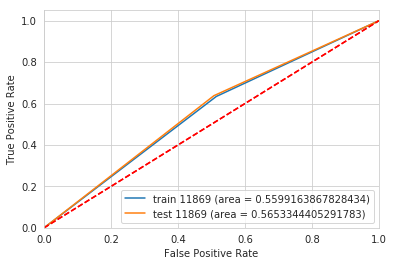

In [8]:
def logistic_regression(df, start_idx, end_idx):
    from sklearn.linear_model import LogisticRegressionCV
    clf = LogisticRegressionCV(fit_intercept=True, solver='sag')
    X = df['queue_imbalance'][start_idx:end_idx].values.reshape(-1, 1)
    y = df['mid_price_avg_indicator_10'][start_idx:end_idx].values.ravel()
    clf.fit(X, y)
    return clf

log_clf = logistic_regression(df, 0, len(df))
pred_train = log_clf.predict(df['queue_imbalance'].values.reshape(-1, 1))
pred_test = log_clf.predict(df_test['queue_imbalance'].values.reshape(-1, 1))
df['pred_log'] = pred_train
df_test['pred_log'] = pred_test
lob.plot_roc(df, log_clf, stock=int(stock), label='train')
lob.plot_roc(df_test, log_clf, stock=int(stock), label='test')

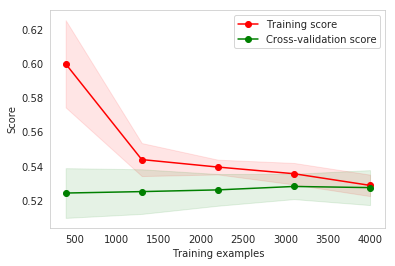

In [9]:
lob.plot_learning_curve(log_clf, df['queue_imbalance'].values.reshape(-1, 1), df['mid_price_avg_indicator_10'])

### Let's look inside

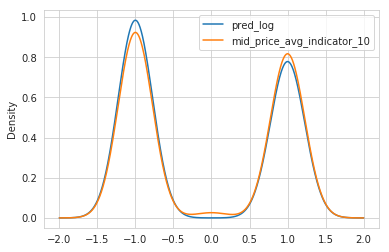

In [10]:
df_test[df_test['pred_log'] != df_test['mid_price_indicator']][['pred_log', 'mid_price_avg_indicator_10']].plot(kind='kde')

In [11]:
print(len(df_test[df_test['pred_log'] != df_test['mid_price_avg_indicator_10']]), len(df_test))
df_test[df_test['pred_log'] != df_test['mid_price_avg_indicator_10']][['pred_log', 'mid_price_avg_indicator_10', 'queue_imbalance']].head()

967 2000


,pred_log,mid_price_avg_indicator_10,queue_imbalance
0,1,0,-0.089655
1,1,0,0.816949
2,1,0,0.414427
3,-1,0,-0.246459
4,-1,0,-0.343977


In [12]:
pivot = min(df[df['pred_log'] == 1]['queue_imbalance'])
pivot

-0.10674157303370786

In [13]:
print('Amount of positive samples below the pivot and negative above the pivot for training data:')
print(len(df[df['queue_imbalance'] < pivot][df['pred_log'] == 1]), 
      len(df[df['queue_imbalance'] >= pivot][df['pred_log'] == 0]))

print('Amount of positive samples below the pivot and negative above the pivot for testing data:')
print(len(df_test[df_test['queue_imbalance'] < pivot][df_test['pred_log'] == 1]), 
      len(df_test[df_test['queue_imbalance'] >= pivot][df_test['pred_log'] == 0]))

Amount of positive samples below the pivot and negative above the pivot for training data:
0 0
Amount of positive samples below the pivot and negative above the pivot for testing data:
2 0


So this classifier just finds a pivot. But why this particular one is choosen? Let's check what amount of data is below and above the pivot.

In [14]:
len(df[df['queue_imbalance'] < pivot]), len(df[df['queue_imbalance'] >= pivot])

(2774, 3226)

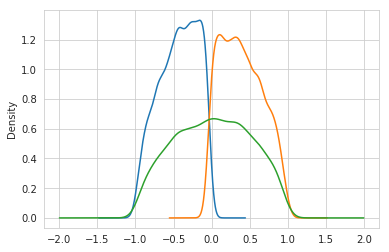

In [15]:
df[df['queue_imbalance'] < pivot]['queue_imbalance'].plot(kind='kde')
df[df['queue_imbalance'] >= pivot]['queue_imbalance'].plot(kind='kde')
df['queue_imbalance'].plot(kind='kde')